In [2]:
!pip install pandas numpy matplotlib statsmodels pandas_datareader yfinance scikit-learn PyPortfolioOpt


In [2]:
!pip install yahooquery


  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl (1.6 MB)


In [65]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta 
import warnings
import time
from yahooquery import Ticker
warnings.filterwarnings('ignore')

In [4]:

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Add headers so Wikipedia doesn't block the request
tables = pd.read_html(url, storage_options={"User-Agent": "Mozilla/5.0"})
sp500 = tables[0]


In [5]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

In [6]:
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [7]:
symbols_list = sp500['Symbol'].unique().tolist()

In [50]:
end_date='2025-09-12'
start_date=pd.to_datetime(end_date)-pd.DateOffset(365*10)


In [51]:
t = Ticker(symbols_list)
df = t.history(start=start_date, end=end_date)

# Clean format
df = df.reset_index().set_index(['date', 'symbol']).sort_index()
df.head()


open       high        low      close     volume  \
date       symbol                                                          
2015-09-15 A       35.750000  36.299999  35.509998  36.150002    1752700   
           AAPL    28.982500  29.132500  28.605000  29.070000  173364800   
           ABBV    58.980000  59.439999  58.369999  59.200001   10474700   
           ABT     43.279999  43.919998  43.110001  43.810001    5105600   
           ACGL    23.273333  23.483334  23.166668  23.406668     941700   

                    adjclose  dividends  splits  
date       symbol                                
2015-09-15 A       33.316147        0.0     0.0  
           AAPL    26.131098        0.0     0.0  
           ABBV    38.981812        0.0     0.0  
           ABT     36.239288        0.0     0.0  
           ACGL    22.257366        0.0     0.0

## features:
.garman klass volatility
.bb bands
.atr
.rsi
.macd
.dollar volume

### first we need it in monthly basis as invesment is v=going to be on monthly basis so should be the candles be

In [122]:
# Convert the 'date' level to datetime if not already
df = df.copy()  # to be safe
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date', 'symbol']).sort_index()

In [123]:
# 1. Ensure datetime index
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date', 'symbol']).sort_index()

# 2. Resample monthly, including dividends
monthly = df.groupby('symbol').resample('M', level='date').agg({
    'open': 'first',       # first day of month
    'high': 'max',         # max high of month
    'low': 'min',          # min low of month
    'close': 'last',       # last close of month
    'volume': 'sum',       # total monthly volume
    'dividends': 'sum'     # total dividends paid during month
})

# 3. Dollar volume
monthly['dollar_volume'] = monthly['close'] * monthly['volume']

# 4. Monthly returns
monthly['return'] = monthly.groupby('symbol')['close'].pct_change()

# 5. Dividend yield (as % of month open)
monthly['div_yield'] = monthly['dividends'] / monthly['open']


In [124]:
monthly = monthly.swaplevel('symbol', 'date')

# Sort by the new index for neatness
monthly = monthly.sort_index()

monthly.head()

open       high        low      close      volume  \
date       symbol                                                           
2015-09-30 A       35.750000  36.990002  33.240002  34.330002    28113400   
           AAPL    28.982500  29.172501  26.965000  27.575001  2614225200   
           ABBV    58.980000  61.830002  51.880001  54.410000   149975000   
           ABT     43.279999  45.150002  39.000000  40.220001   102695600   
           ACGL    23.273333  24.709999  22.873333  24.490000    21576900   

                   dividends  dollar_volume  return  div_yield  
date       symbol                                               
2015-09-30 A             0.1   9.651331e+08     NaN   0.002797  
           AAPL          0.0   7.208726e+10     NaN   0.000000  
           ABBV          0.0   8.160140e+09     NaN   0.000000  
           ABT           0.0   4.130417e+09     NaN   0.000000  
           ACGL          0.0   5.284183e+08     NaN   0.000000

In [129]:
def compute_bb_rsi_atr(group):
    group = group.sort_index()
    
    # RSI
    group['rsi'] = ta.rsi(group['close'], length=14)
    
    # Bollinger Bands
    bb = ta.bbands(group['close'], length=20)
    if bb is not None:
        group['bb_low']  = bb['BBL_20_2.0']
        group['bb_mid']  = bb['BBM_20_2.0']
        group['bb_high'] = bb['BBU_20_2.0']
    else:
        group['bb_low'] = np.nan
        group['bb_mid'] = np.nan
        group['bb_high'] = np.nan
    
    # ATR
    atr = ta.atr(high=group['high'], low=group['low'], close=group['close'], length=14)
    if atr is not None:
        group['atr'] = atr
    else:
        group['atr'] = np.nan
    
    return group

monthly = monthly.groupby('symbol', group_keys=False).apply(compute_bb_rsi_atr)
monthly.head()

open       high        low      close      volume  \
date       symbol                                                           
2015-09-30 A       35.750000  36.990002  33.240002  34.330002    28113400   
           AAPL    28.982500  29.172501  26.965000  27.575001  2614225200   
           ABBV    58.980000  61.830002  51.880001  54.410000   149975000   
           ABT     43.279999  45.150002  39.000000  40.220001   102695600   
           ACGL    23.273333  24.709999  22.873333  24.490000    21576900   

                   dividends  dollar_volume  return  div_yield  rsi  bb_low  \
date       symbol                                                             
2015-09-30 A             0.1   9.651331e+08     NaN   0.002797  NaN     NaN   
           AAPL          0.0   7.208726e+10     NaN   0.000000  NaN     NaN   
           ABBV          0.0   8.160140e+09     NaN   0.000000  NaN     NaN   
           ABT           0.0   4.130417e+09     NaN   0.000000  NaN     NaN   
           ACGL          0.0   5.284183e+08     NaN   0.000000  NaN     NaN   

                   bb_mid  bb_high  atr  
date       symbol                        
2015-09-30 A          NaN      NaN  NaN  
           AAPL       NaN      NaN  NaN  
           ABBV       NaN      NaN  NaN  
           ABT        NaN      NaN  NaN  
           ACGL       NaN      NaN  NaN

In [130]:
monthly['dollar_volume']=monthly['dollar_volume']/1e6

In [131]:
monthly.head()

open       high        low      close      volume  \
date       symbol                                                           
2015-09-30 A       35.750000  36.990002  33.240002  34.330002    28113400   
           AAPL    28.982500  29.172501  26.965000  27.575001  2614225200   
           ABBV    58.980000  61.830002  51.880001  54.410000   149975000   
           ABT     43.279999  45.150002  39.000000  40.220001   102695600   
           ACGL    23.273333  24.709999  22.873333  24.490000    21576900   

                   dividends  dollar_volume  return  div_yield  rsi  bb_low  \
date       symbol                                                             
2015-09-30 A             0.1     965.133073     NaN   0.002797  NaN     NaN   
           AAPL          0.0   72087.261884     NaN   0.000000  NaN     NaN   
           ABBV          0.0    8160.139727     NaN   0.000000  NaN     NaN   
           ABT           0.0    4130.417157     NaN   0.000000  NaN     NaN   
           ACGL          0.0     528.418276     NaN   0.000000  NaN     NaN   

                   bb_mid  bb_high  atr  
date       symbol                        
2015-09-30 A          NaN      NaN  NaN  
           AAPL       NaN      NaN  NaN  
           ABBV       NaN      NaN  NaN  
           ABT        NaN      NaN  NaN  
           ACGL       NaN      NaN  NaN

In [132]:
month2=monthly.copy()

In [133]:
# Check index levels
monthly.index.names
# ['date', 'symbol']  <-- this is likely

# Fix unstack
monthly['dollar_volume'] = (
    monthly['dollar_volume']
    .unstack('symbol')                  # use 'symbol', not 'ticker'
    .rolling(5*12, min_periods=12).mean()
    .stack()
)

# Rank by dollar volume per month
monthly['dollar_vol_rank'] = monthly.groupby('date')['dollar_volume'].rank(ascending=False)

# Keep top 150 stocks per month
monthly = monthly[monthly['dollar_vol_rank'] < 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)


In [134]:
monthly.head()

open        high         low       close      volume  \
date       symbol                                                               
2016-08-31 AAPL     26.102501   27.557501   26.000000   26.525000  2520514000   
           ABBV     66.230003   68.120003   63.500000   64.099998   150348400   
           ABT      44.750000   45.790001   41.930000   42.020000   227349600   
           ACN     112.580002  116.199997  111.730003  115.000000    42291400   
           ADBE     97.750000  102.750000   95.419998  102.309998    37652700   

                   dividends    return  div_yield  rsi  bb_low  bb_mid  \
date       symbol                                                        
2016-08-31 AAPL       0.1425  0.018136   0.005459  NaN     NaN     NaN   
           ABBV       0.0000 -0.032161   0.000000  NaN     NaN     NaN   
           ABT        0.0000 -0.061006   0.000000  NaN     NaN     NaN   
           ACN        0.0000  0.019413   0.000000  NaN     NaN     NaN   
           ADBE       0.0000  0.045473   0.000000  NaN     NaN     NaN   

                   bb_high  atr  
date       symbol                
2016-08-31 AAPL        NaN  NaN  
           ABBV        NaN  NaN  
           ABT         NaN  NaN  
           ACN         NaN  NaN  
           ADBE        NaN  NaN

In [135]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1]

    for lag in lags:

        df[f'return_{lag}m'] = (df['close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
monthly = monthly.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

monthly.head()

open        high         low       close      volume  \
date       symbol                                                               
2017-04-30 AAPL     35.927502   36.365002   35.014999   35.912498  1493216400   
           ABBV     65.239998   67.500000   63.119999   65.940002   103923600   
           ABT      44.419998   44.610001   42.310001   43.639999   135569400   
           ACN     118.000000  121.349998  114.820000  121.300003    42332600   
           ADBE    129.589996  134.250000  128.210007  133.740005    38277400   

                   dividends    return  div_yield        rsi     bb_low  \
date       symbol                                                         
2017-04-30 AAPL        0.000 -0.000070   0.000000  73.136438  20.957926   
           ABBV        0.640  0.011971   0.009810  62.233997  53.264758   
           ABT         0.265 -0.017338   0.005966  55.817606  36.329159   
           ACN         1.210  0.011845   0.010254  61.652709  99.197961   
           ADBE        0.000  0.027741   0.000000  83.431274  74.548238   

                       bb_mid     bb_high       atr  return_1m  
date       symbol                                               
2017-04-30 AAPL     28.180875   35.403824  2.581204  -0.000070  
           ABBV     60.523500   67.782243  5.645045   0.011971  
           ABT      41.539500   46.749841  3.593185  -0.017338  
           ACN     113.194500  127.191039  8.871382   0.011845  
           ADBE    101.570501  128.592763  9.072464   0.027741

In [136]:
monthly.dropna(inplace=True)

# Download Fama-French Factors and Calculate Rolling Factor Betas.
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression

In [137]:
ff_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2016')[0].drop('RF', axis=1)
factor_data = ff_factors
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'
factor_data = factor_data.join(monthly['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       symbol                                                   
2017-04-30 AAPL    0.0108  0.0041 -0.0205  0.0179 -0.0160  -0.000070
           ABBV    0.0108  0.0041 -0.0205  0.0179 -0.0160   0.011971
           ABT     0.0108  0.0041 -0.0205  0.0179 -0.0160  -0.017338
           ACN     0.0108  0.0041 -0.0205  0.0179 -0.0160   0.011845
           ADBE    0.0108  0.0041 -0.0205  0.0179 -0.0160   0.027741
...                   ...     ...     ...     ...     ...        ...
2025-06-30 WDAY    0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.031125
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763
           XYZ     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.100081

[14642 rows x 6 columns]

In [138]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('symbol').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       symbol                                                   
2017-04-30 AAPL    0.0108  0.0041 -0.0205  0.0179 -0.0160  -0.000070
           ABBV    0.0108  0.0041 -0.0205  0.0179 -0.0160   0.011971
           ABT     0.0108  0.0041 -0.0205  0.0179 -0.0160  -0.017338
           ACN     0.0108  0.0041 -0.0205  0.0179 -0.0160   0.011845
           ADBE    0.0108  0.0041 -0.0205  0.0179 -0.0160   0.027741
...                   ...     ...     ...     ...     ...        ...
2025-06-30 WDAY    0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.031125
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763
           XYZ     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.100081

[14593 rows x 6 columns]

In [139]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       symbol                                                  
2017-04-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 WDAY    1.073699 -1.137843  0.630665 -1.472602 -0.444183
           WFC     0.734734 -0.064020  0.511381 -1.762498 -0.027755
           WMT     0.535830  0.096271 -0.390957  0.208256 -0.912810
           XOM     0.252923 -0.240159  0.863312  0.606630  0.254980
           XYZ     2.111211  0.216082  0.078459 -4.296295 -0.207429

[14593 rows x 5 columns]

In [142]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# 1. Shift betas by 1 month inside each ticker group
betas = betas.groupby('symbol').shift(1)

# 2. Join shifted betas back to data
monthly = monthly.join(betas)

# 3. Handle missing factor exposures
#    Better: forward-fill per ticker (instead of using the mean which leaks info)
monthly.loc[:, factors] = monthly.groupby('symbol')[factors].ffill()

# 4. Drop unwanted columns
monthly = monthly.drop(columns=['close','open','high','low','close'])

# 5. Optional: drop rows that still have NA (like first 24 months for each stock)
monthly = monthly.dropna()

monthly.info()


ValueError: columns overlap but no suffix specified: Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

# At this point we have to decide on what ML model and approach to use for predictions etc.
# 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
K-Means Clustering
You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [141]:
monthly.head()

open        high         low       close      volume  \
date       symbol                                                               
2017-04-30 AAPL     35.927502   36.365002   35.014999   35.912498  1493216400   
           ABBV     65.239998   67.500000   63.119999   65.940002   103923600   
           ABT      44.419998   44.610001   42.310001   43.639999   135569400   
           ACN     118.000000  121.349998  114.820000  121.300003    42332600   
           ADBE    129.589996  134.250000  128.210007  133.740005    38277400   

                   dividends    return  div_yield        rsi     bb_low  \
date       symbol                                                         
2017-04-30 AAPL        0.000 -0.000070   0.000000  73.136438  20.957926   
           ABBV        0.640  0.011971   0.009810  62.233997  53.264758   
           ABT         0.265 -0.017338   0.005966  55.817606  36.329159   
           ACN         1.210  0.011845   0.010254  61.652709  99.197961   
           ADBE        0.000  0.027741   0.000000  83.431274  74.548238   

                       bb_mid     bb_high       atr  return_1m  Mkt-RF  SMB  \
date       symbol                                                             
2017-04-30 AAPL     28.180875   35.403824  2.581204  -0.000070     NaN  NaN   
           ABBV     60.523500   67.782243  5.645045   0.011971     NaN  NaN   
           ABT      41.539500   46.749841  3.593185  -0.017338     NaN  NaN   
           ACN     113.194500  127.191039  8.871382   0.011845     NaN  NaN   
           ADBE    101.570501  128.592763  9.072464   0.027741     NaN  NaN   

                   HML  RMW  CMA  
date       symbol                 
2017-04-30 AAPL    NaN  NaN  NaN  
           ABBV    NaN  NaN  NaN  
           ABT     NaN  NaN  NaN  
           ACN     NaN  NaN  NaN  
           ADBE    NaN  NaN  NaN

In [143]:
monthly = monthly.drop(columns=['close','open','high','low','close'])

# 5. Optional: drop rows that still have NA (like first 24 months for each stock)
monthly = monthly.dropna()


In [144]:
monthly.head()

volume  dividends    return  div_yield        rsi  \
date       symbol                                                          
2019-04-30 AAPL    2024470800       0.00  0.056436   0.000000  59.980610   
           ABBV     127085000       1.07 -0.014890   0.013213  46.829281   
           ABT      118461000       0.32 -0.004754   0.003967  76.362147   
           ACN       35897100       1.46  0.037780   0.008319  66.640588   
           ADBE      46806300       0.00  0.085407   0.000000  74.945697   

                       bb_low      bb_mid     bb_high        atr  return_1m  \
date       symbol                                                             
2019-04-30 AAPL     35.114595   45.548250   55.981904   5.348928   0.056436   
           ABBV     72.891893   92.509501  112.127108  10.834201  -0.014890   
           ABT      49.082699   65.762501   82.442303   5.739003  -0.004754   
           ACN     135.255289  157.982000  180.708711  12.973121   0.037780   
           ADBE    156.025612  229.390001  302.754390  26.263357   0.085407   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       symbol                                                    
2019-04-30 AAPL    0.411642 -0.103264 -0.938677  0.385368 -2.063919  
           ABBV    0.814430 -0.917040  0.837975 -2.066314 -1.158388  
           ABT     0.755382 -0.346633 -0.409398 -0.506819  0.555587  
           ACN     1.135403 -0.087592 -0.382532  0.222416 -0.076952  
           ADBE    0.760888 -0.438867  0.446040 -0.843606 -2.795524

In [145]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10558 entries, (Timestamp('2019-04-30 00:00:00'), 'AAPL') to (Timestamp('2025-09-30 00:00:00'), 'XYZ')
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   volume     10558 non-null  int64  
 1   dividends  10558 non-null  float64
 2   return     10558 non-null  float64
 3   div_yield  10558 non-null  float64
 4   rsi        10558 non-null  float64
 5   bb_low     10558 non-null  float64
 6   bb_mid     10558 non-null  float64
 7   bb_high    10558 non-null  float64
 8   atr        10558 non-null  float64
 9   return_1m  10558 non-null  float64
 10  Mkt-RF     10558 non-null  float64
 11  SMB        10558 non-null  float64
 12  HML        10558 non-null  float64
 13  RMW        10558 non-null  float64
 14  CMA        10558 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 1.3+ MB


In [146]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def get_clusters_hierarchical(df, n_clusters=4, linkage='ward'):
    # use only numeric features for clustering
    X = df.select_dtypes(include=[np.number]).values
    
    # If too few stocks, assign noise cluster
    if len(df) < n_clusters:
        df['cluster'] = -1
        return df
    
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    df['cluster'] = model.fit_predict(X)
    return df


In [148]:
monthly = monthly.dropna().groupby('date', group_keys=False).apply(get_clusters_hierarchical)

In [149]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


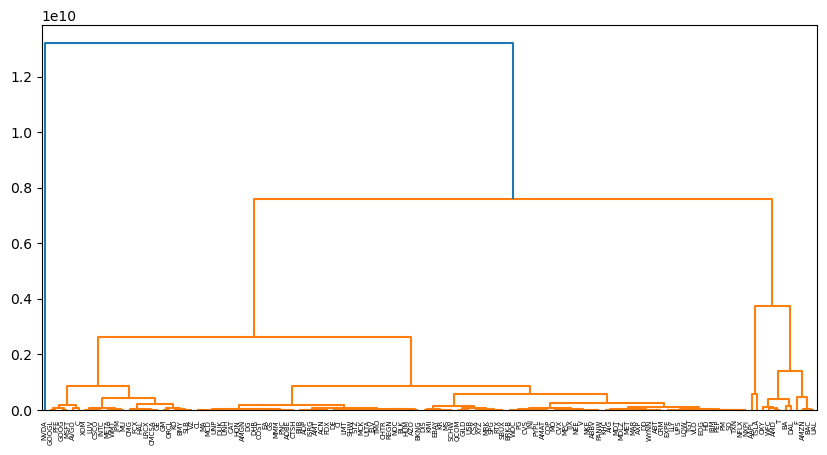

In [151]:
sample_month = monthly.loc['2020-06-30']  # pick a month
X = sample_month.select_dtypes(include=[np.number]).values

Z = linkage(X, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=sample_month.index.get_level_values('symbol'))
plt.show()

In [152]:
sample_month[['cluster']].value_counts()


cluster
0          124
2           10
1            2
3            1
Name: count, dtype: int64

In [153]:
sample_month.groupby('cluster').mean()


,volume,dividends,return,div_yield,rsi,bb_low,bb_mid,bb_high,atr,return_1m,Mkt-RF,SMB,HML,RMW,CMA
cluster,,,,,,,,,,,,,,,
0,2.132176e+08,0.163947,0.009662,0.001608,52.737570,107.022649,141.568927,176.115205,20.272647,0.009686,1.003334,0.027415,0.040248,-0.074446,0.169992
1,3.539983e+09,0.000000,0.220286,0.000000,76.748182,13.179460,43.675404,74.171348,9.752490,0.220286,1.362834,-0.473369,-0.098465,0.207105,0.264902
2,1.496510e+09,0.019000,0.112048,0.000819,43.094406,35.549289,71.912484,108.275680,12.863623,0.112048,1.332864,-0.476001,0.744508,-1.360889,-0.045031
3,9.719464e+09,0.004000,0.070109,0.000453,77.831885,1.835807,5.269825,8.703843,1.172905,0.070109,0.834757,0.691831,-0.986583,1.497043,-2.425963


In [154]:
sample_month.groupby('cluster')['return_1m'].describe()


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,124.0,0.009686,0.073648,-0.166346,-0.033674,-0.005090,0.047547,0.294277
1,2.0,0.220286,0.103096,0.147386,0.183836,0.220286,0.256736,0.293186
2,10.0,0.112048,0.149761,-0.032867,-0.019146,0.088726,0.208123,0.413127
3,1.0,0.070109,NaN,0.070109,0.070109,0.070109,0.070109,0.070109


In [155]:
from sklearn.mixture import GaussianMixture

X = sample_month.select_dtypes(include=[np.number]).values
gmm = GaussianMixture(n_components=4, random_state=0)
sample_month['cluster_gmm'] = gmm.fit_predict(X)

In [157]:
sample_month.describe()

,volume,dividends,return,div_yield,rsi,bb_low,bb_mid,bb_high,atr,return_1m,Mkt-RF,SMB,HML,RMW,CMA,cluster,cluster_gmm
count,1.370000e+02,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,4.248432e+08,0.149806,0.020652,0.001518,52.567379,99.667855,134.060529,168.453202,19.438850,0.020674,1.031405,-0.011791,0.082134,-0.152766,0.136734,0.182482,2.416058
std,9.730917e+08,0.420231,0.088335,0.003454,13.162427,146.626449,186.680163,228.485486,28.184596,0.088294,0.468322,1.017122,0.785101,1.850402,1.358050,0.584342,1.148159
min,5.164600e+06,0.000000,-0.166346,0.000000,26.699627,-3.691047,5.269825,8.703843,1.172905,-0.166346,-0.229874,-2.694294,-1.803426,-5.230170,-5.283337,0.000000,0.000000
25%,8.534900e+07,0.000000,-0.032867,0.000000,41.294742,33.251115,48.916500,62.777544,7.453723,-0.032867,0.785839,-0.706247,-0.488634,-1.314328,-0.721240,0.000000,3.000000
50%,1.665301e+08,0.000000,-0.004331,0.000000,52.176020,65.810017,82.512000,104.753063,12.217295,-0.004331,1.023334,-0.067873,0.008411,-0.120422,0.146060,0.000000,3.000000
75%,3.853928e+08,0.000000,0.064798,0.000000,61.977446,129.709645,159.074502,193.276091,22.015044,0.064798,1.313366,0.589712,0.667723,0.767628,0.930917,0.000000,3.000000
max,9.719464e+09,3.630000,0.413127,0.021483,83.504630,1425.836551,1784.050006,2142.263461,278.566563,0.413127,2.398237,3.821891,2.434345,6.378084,2.938786,3.000000,3.000000


In [158]:
sample_month.groupby('cluster').mean()[['rsi','atr','return_1m']]

,rsi,atr,return_1m
cluster,,,
0,52.737570,20.272647,0.009686
1,76.748182,9.752490,0.220286
2,43.094406,12.863623,0.112048
3,77.831885,1.172905,0.070109


In [159]:
monthly.groupby(['cluster']).size()


cluster
0    3834
1    3163
2    3337
3     224
dtype: int64

<Axes: xlabel='date'>

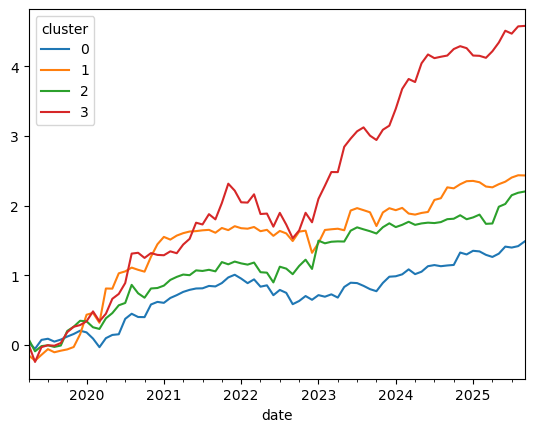

In [160]:
monthly.groupby(['date','cluster'])['return_1m'].mean().unstack().cumsum().plot()


In [208]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10558 entries, (Timestamp('2019-04-30 00:00:00'), 'AAPL') to (Timestamp('2025-09-30 00:00:00'), 'XYZ')
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   volume     10558 non-null  int64  
 1   dividends  10558 non-null  float64
 2   return     10558 non-null  float64
 3   div_yield  10558 non-null  float64
 4   rsi        10558 non-null  float64
 5   bb_low     10558 non-null  float64
 6   bb_mid     10558 non-null  float64
 7   bb_high    10558 non-null  float64
 8   atr        10558 non-null  float64
 9   return_1m  10558 non-null  float64
 10  Mkt-RF     10558 non-null  float64
 11  SMB        10558 non-null  float64
 12  HML        10558 non-null  float64
 13  RMW        10558 non-null  float64
 14  CMA        10558 non-null  float64
 15  cluster    10558 non-null  int64  
dtypes: float64(14), int64(2)
memory usage: 1.3+ MB


In [164]:
monthly=monthly.copy()

In [170]:

n_stocks = 50

def select_portfolio(group):
    """
    Selects up to n_stocks from clusters 1,2,3 with highest return_1m.
    If fewer than n_stocks, fill remaining with cluster 0 by return_1m.
    """
    # Keep clusters 1,2,3 first
    primary = group[group['cluster'].isin([1, 2, 3])].sort_values('return_1m', ascending=False)
    
    # If fewer than n_stocks, fill with cluster 0
    if len(primary) < n_stocks:
        remaining = n_stocks - len(primary)
        fill = group[group['cluster'] == 0].sort_values('return_1m', ascending=False).head(remaining)
        primary = pd.concat([primary, fill])
    else:
        primary = primary.head(n_stocks)
    
    return primary

# Apply month-wise selection
portfolio_monthly = monthly.groupby('date', group_keys=False).apply(select_portfolio)

# Compute equal-weighted portfolio return per month
portfolio_returns = portfolio_monthly.groupby('date')['return_1m'].mean().rename('port_return')

portfolio_returns.head()


date
2019-04-30    0.103862
2019-05-31   -0.013757
2019-06-30    0.132221
2019-07-31    0.065135
2019-08-31    0.050852
Name: port_return, dtype: float64

In [209]:
n_stocks = 50

def select_portfolio(group):
    """
    Selects up to n_stocks from clusters 1,2,3 with highest return_1m.
    Fills with cluster 0 only if fewer than n_stocks.
    """
    # Sort clusters 1,2,3 by return_1m
    primary = group[group['cluster'].isin([1, 2, 3])].sort_values('return_1m', ascending=False)
    
    # Fill with cluster 0 if not enough
    if len(primary) < n_stocks:
        remaining = n_stocks - len(primary)
        fill = group[group['cluster'] == 0].sort_values('return_1m', ascending=False).head(remaining)
        primary = pd.concat([primary, fill])
    
    # Take only top n_stocks (in case clusters 1-3 exceed n_stocks)
    primary = primary.head(n_stocks)
    
    return primary

# Apply month-wise selection
portfolio_monthly = monthly.groupby('date', group_keys=False).apply(select_portfolio)

# Compute equal-weighted portfolio return per month
portfolio_returns = (
    portfolio_monthly
    .groupby('date')['return_1m']
    .mean()
    .rename('port_return')
)

# Check first few months
portfolio_returns.head()


date
2019-04-30    0.103862
2019-05-31   -0.013757
2019-06-30    0.132221
2019-07-31    0.065135
2019-08-31    0.050852
Name: port_return, dtype: float64

In [210]:
end_date='2025-09-12'
start_date='2019-04-30'

In [211]:
t = Ticker(['^GSPC'])
df = t.history(start=start_date, end=end_date)

# Clean format
df = df.reset_index().set_index(['date', 'symbol']).sort_index()
df.head()


,,open,high,low,close,volume,adjclose
date,symbol,,,,,,
2019-04-30,^GSPC,2937.139893,2948.219971,2924.110107,2945.830078,3939760000,2945.830078
2019-05-01,^GSPC,2952.330078,2954.129883,2923.360107,2923.729980,3669330000,2923.729980
2019-05-02,^GSPC,2922.159912,2931.679932,2900.500000,2917.520020,3802290000,2917.520020
2019-05-03,^GSPC,2929.209961,2947.850098,2929.209961,2945.639893,3357180000,2945.639893
2019-05-06,^GSPC,2908.889893,2937.320068,2898.209961,2932.469971,3203260000,2932.469971


In [212]:
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date', 'symbol']).sort_index()

# 2. Resample monthly, including dividends
df2= df.groupby('symbol').resample('M', level='date').agg({
    'open': 'first',       # first day of month
    'high': 'max',         # max high of month
    'low': 'min',          # min low of month
    'close': 'last',       # last close of month
    'volume': 'sum'     # total monthly volume
        # total dividends paid during month
})


# 4. Monthly returns
df2['return'] = df2.groupby('symbol')['close'].pct_change()


In [213]:
# Assuming you have S&P 500 in df2 with symbol '^GSPC'
sp500_monthly = df2.xs('^GSPC', level='symbol')['return'].rename('sp500_return')

# Combine portfolio vs S&P 500
comparison = pd.concat([portfolio_returns, sp500_monthly], axis=1).dropna()
comparison.head()

,port_return,sp500_return
date,,
2019-05-31,-0.013757,-0.065778
2019-06-30,0.132221,0.068930
2019-07-31,0.065135,0.013128
2019-08-31,0.050852,-0.018092
2019-09-30,0.070766,0.017181


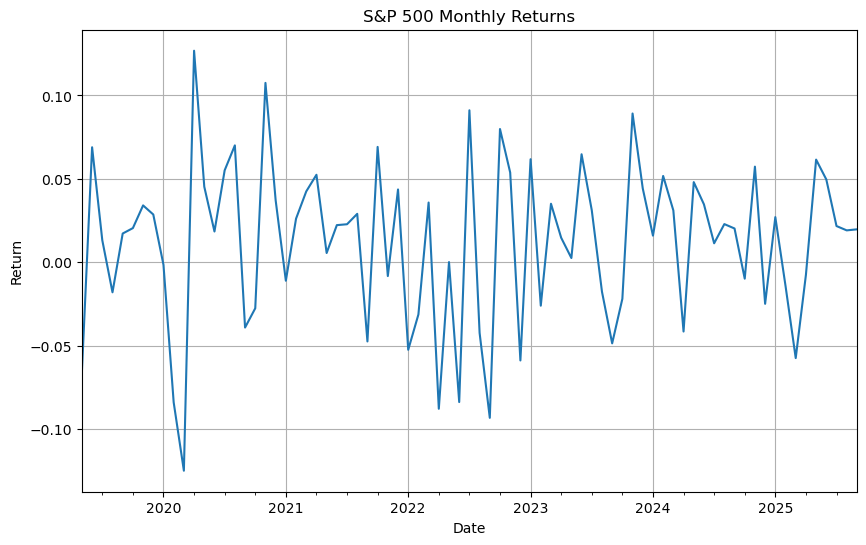

In [214]:
comparison.index = pd.to_datetime(comparison.index)

# Plot S&P 500 monthly returns
comparison['sp500_return'].plot(figsize=(10,6), title='S&P 500 Monthly Returns')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(True)
plt.show()


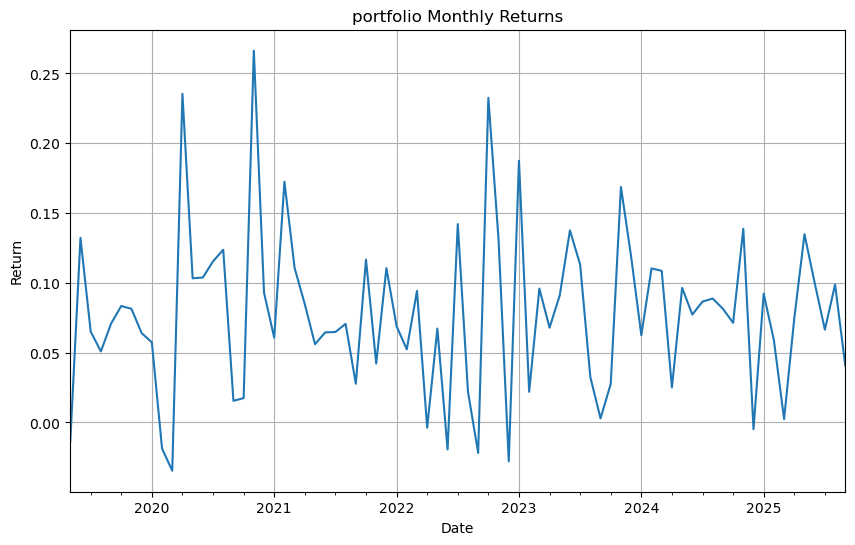

In [215]:
comparison['port_return'].plot(figsize=(10,6), title='portfolio Monthly Returns')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(True)
plt.show()


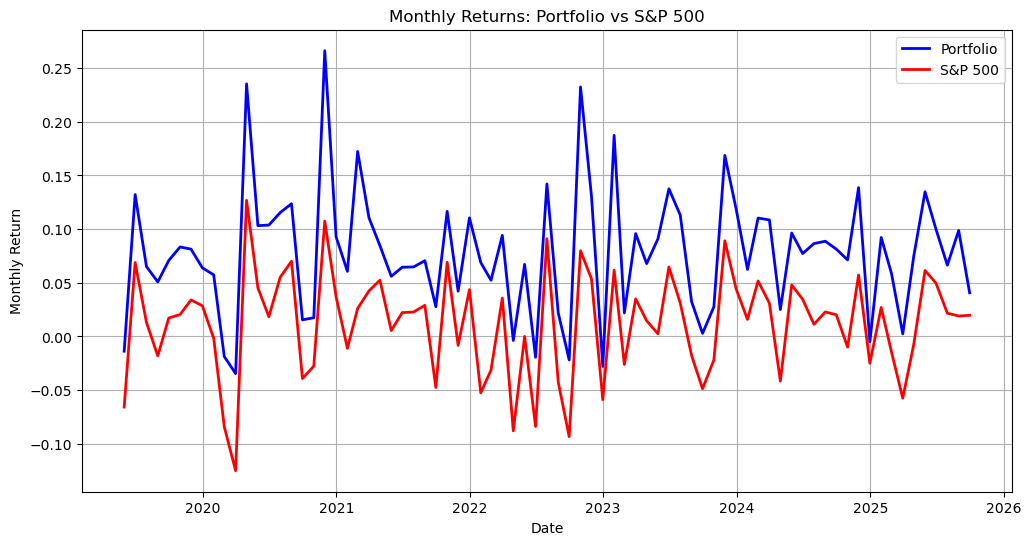

In [223]:
import matplotlib.pyplot as plt

# Ensure datetime index
comparison.index = pd.to_datetime(comparison.index)

plt.figure(figsize=(12,6))
plt.plot(comparison.index, comparison['port_return'], label='Portfolio', color='blue', linewidth=2)
plt.plot(comparison.index, comparison['sp500_return'], label='S&P 500', color='red', linewidth=2)
plt.title('Monthly Returns: Portfolio vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.show()
